In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV

In [119]:
sns.set_palette("plasma")

In [185]:
df= pd.read_csv('data.txt', sep ='	')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [186]:
df.shape

(45211, 17)

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [123]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


# 1.  Data cleansing and missing value treatment

In [124]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

There are many categorical variables represented in the set - you can see this in the info. However, these columns do not represent the ‘categorical’ type, so an explicit type conversion will be performed to optimise the dataset.

In [188]:
cat_columns = df.select_dtypes(include=['object']).columns.tolist()

for col in cat_columns:
    df[col] = df[col].astype('category')

print("Categorical columns:")

for col in cat_columns:
    print(f"\n Name: {col}")
    print(f"Values: {df[col].unique()}") 

Categorical columns:

 Name: job
Values: ['management', 'technician', 'entrepreneur', 'blue-collar', 'unknown', ..., 'services', 'self-employed', 'unemployed', 'housemaid', 'student']
Length: 12
Categories (12, object): ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', ..., 'student', 'technician', 'unemployed', 'unknown']

 Name: marital
Values: ['married', 'single', 'divorced']
Categories (3, object): ['divorced', 'married', 'single']

 Name: education
Values: ['tertiary', 'secondary', 'unknown', 'primary']
Categories (4, object): ['primary', 'secondary', 'tertiary', 'unknown']

 Name: default
Values: ['no', 'yes']
Categories (2, object): ['no', 'yes']

 Name: housing
Values: ['yes', 'no']
Categories (2, object): ['no', 'yes']

 Name: loan
Values: ['no', 'yes']
Categories (2, object): ['no', 'yes']

 Name: contact
Values: ['unknown', 'cellular', 'telephone']
Categories (3, object): ['cellular', 'telephone', 'unknown']

 Name: month
Values: ['may', 'jun', 'jul', 'aug', 'oct', ...

In [126]:
len(cat_columns)

10

There were no missing values in the dataset initially. If we consider the value ‘unknown’ in the categorical columns as missing values, we can see that they are present in the columns job, education, contact, poutcome.

In [189]:
all_rows = df.shape[0]
for col in cat_columns:
    count = (df[col] == "unknown").sum()
    percentage = (count/all_rows)*100
    print(f"Column name: {col} \t'Unknown' values: {count}  \t  Percentage in the dataset: {percentage}")

Column name: job 	'Unknown' values: 288  	  Percentage in the dataset: 0.6370131162770122
Column name: marital 	'Unknown' values: 0  	  Percentage in the dataset: 0.0
Column name: education 	'Unknown' values: 1857  	  Percentage in the dataset: 4.1074074893278185
Column name: default 	'Unknown' values: 0  	  Percentage in the dataset: 0.0
Column name: housing 	'Unknown' values: 0  	  Percentage in the dataset: 0.0
Column name: loan 	'Unknown' values: 0  	  Percentage in the dataset: 0.0
Column name: contact 	'Unknown' values: 13020  	  Percentage in the dataset: 28.798301298356595
Column name: month 	'Unknown' values: 0  	  Percentage in the dataset: 0.0
Column name: poutcome 	'Unknown' values: 36959  	  Percentage in the dataset: 81.74780473778506
Column name: y 	'Unknown' values: 0  	  Percentage in the dataset: 0.0


Let's identify the rows that are missing all values for the set of columns with missing values. Let's then delete them

In [190]:
cols_with_unknown = ["job", "education", "contact", "poutcome"]
rows_to_drop = df[(df[cols_with_unknown] == "unknown").all(axis=1)]

print(f"There are {len(rows_to_drop)} rows with unknown values in all columns from the subset")

There are 54 rows with unknown values in all columns from the subset


In [191]:
df = df.drop(rows_to_drop.index).reset_index(drop=True)

In [192]:
df.isin(["unknown"]).sum()

age              0
job            234
marital          0
education     1803
default          0
balance          0
housing          0
loan             0
contact      12966
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36905
y                0
dtype: int64

For columns with a small number of missing values, I will replace these values with mode value. 

In [193]:
df['job'].replace("unknown", df["job"].mode()[0], inplace=True)
df["education"].replace("unknown", df["education"].mode()[0], inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_4904\2918525700.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(df["job"].unique(), rotation=75)


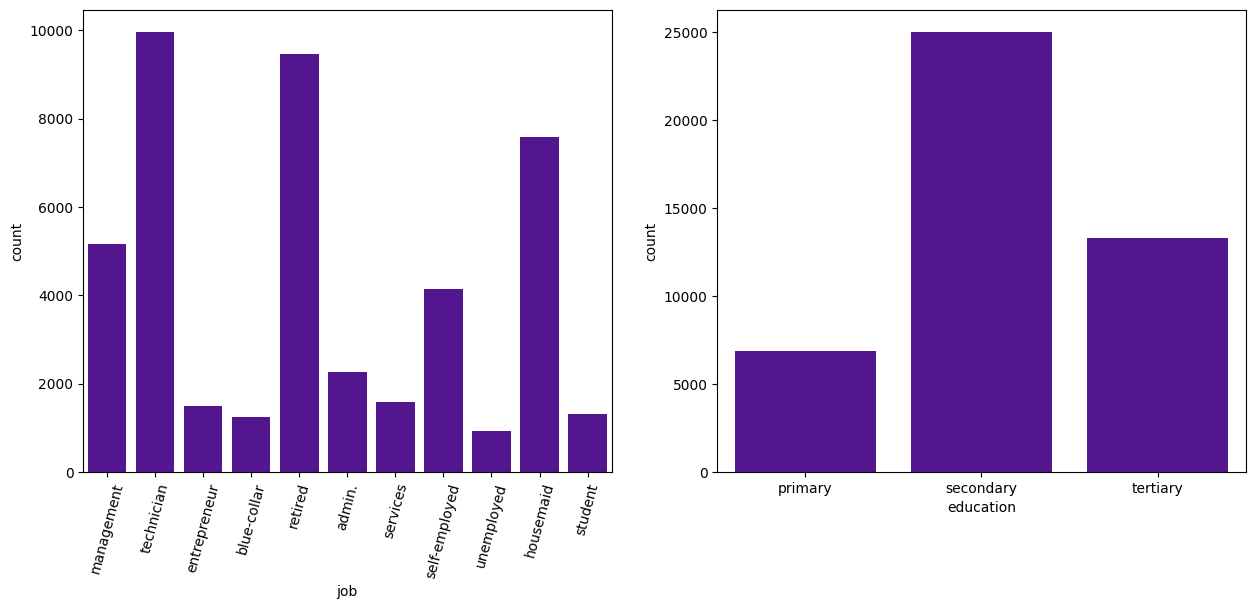

In [194]:
fig, axs = plt.subplots(1, 2, figsize =(15, 6))
sns.countplot(data = df, x = "job", ax = axs[0])
axs[0].set_xticklabels(df["job"].unique(), rotation=75)
sns.countplot(data = df, x = "education", ax = axs[1])
plt.show()

Almost all of the values in the poutcome column are missing values, so it can be assumed that it has little or no meaningful load and can be easily removed from the dataset. 

In [195]:
df['poutcome'].unique()

['unknown', 'failure', 'other', 'success']
Categories (4, object): ['failure', 'other', 'success', 'unknown']

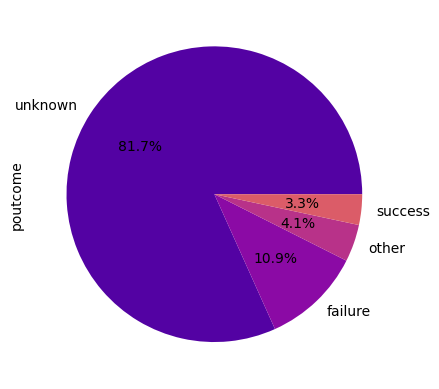

In [196]:
df['poutcome'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

In [197]:
df.drop(columns=["poutcome"], inplace=True)
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'y'],
      dtype='object')

In the contact column, missing values account for a significant portion, but not the largest portion. At this point, the resulting percentage of such records is too large to safely delete records without losing a large number of records and to replace with a mod without threatening to confuse the results. For now, the missing values will remain in the column as a category, to further influence the column and such values on other variables and on the target variable.

In [136]:
df['contact'].unique()

['unknown', 'cellular', 'telephone']
Categories (3, object): ['cellular', 'telephone', 'unknown']

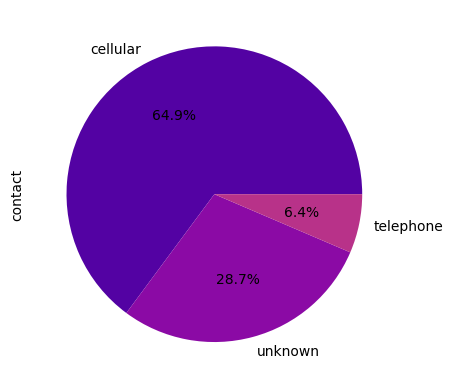

In [198]:
df['contact'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

# 2.  Exploratory data analysis and visual plotting

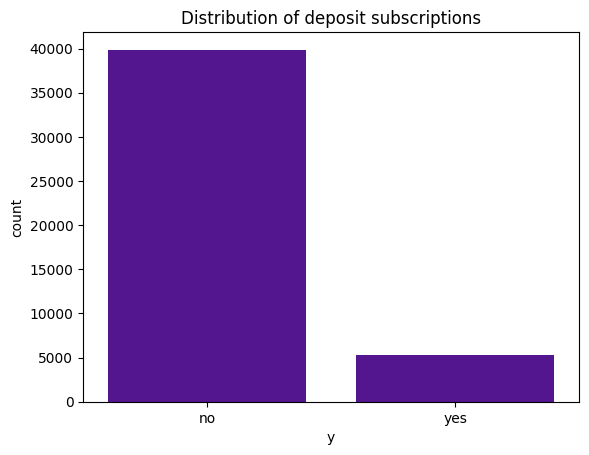

In [138]:
sns.countplot(data=df, x='y')
plt.title("Distribution of deposit subscriptions")
plt.show()

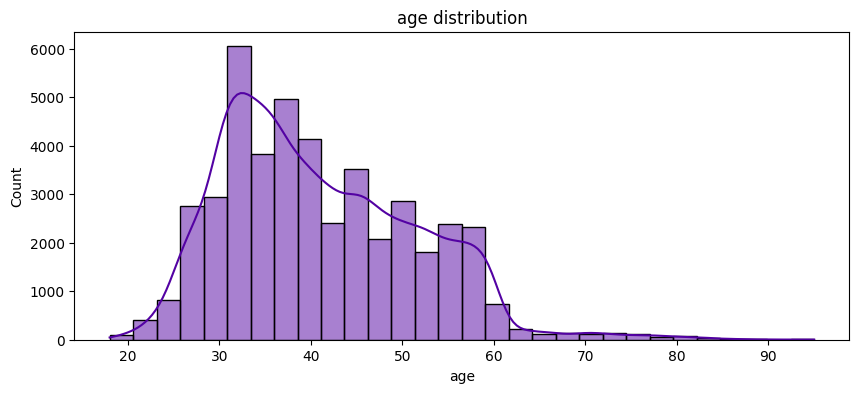

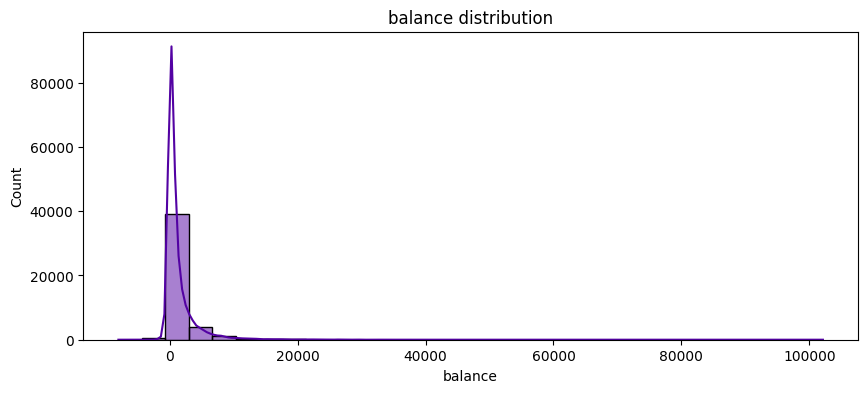

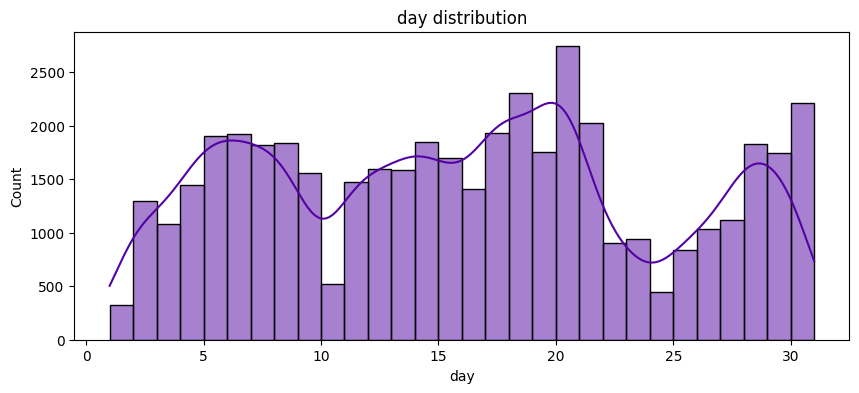

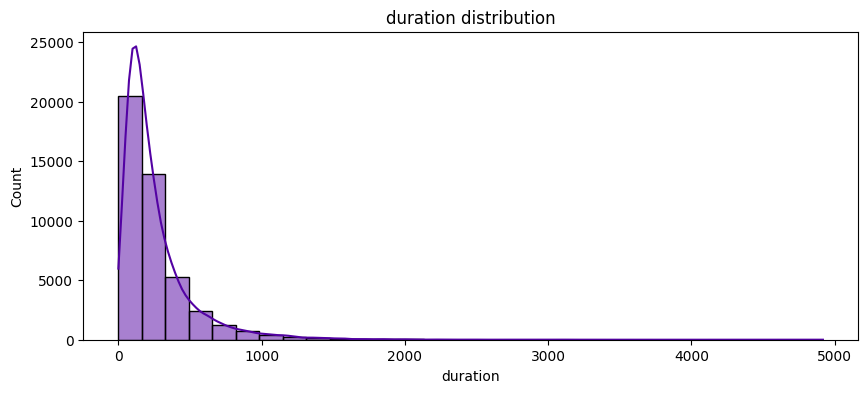

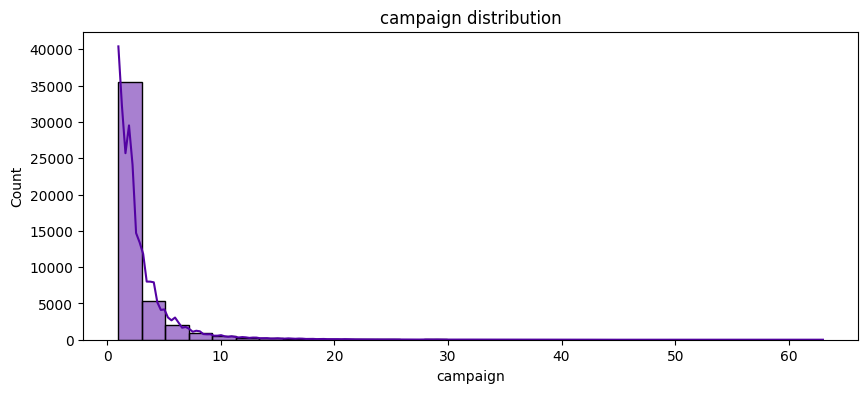

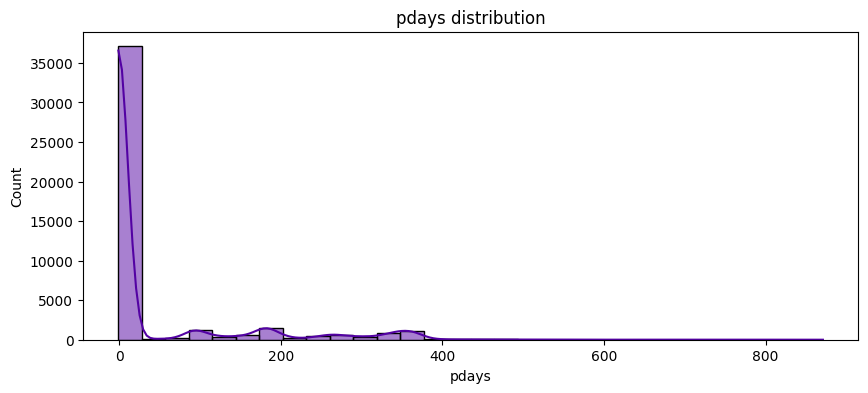

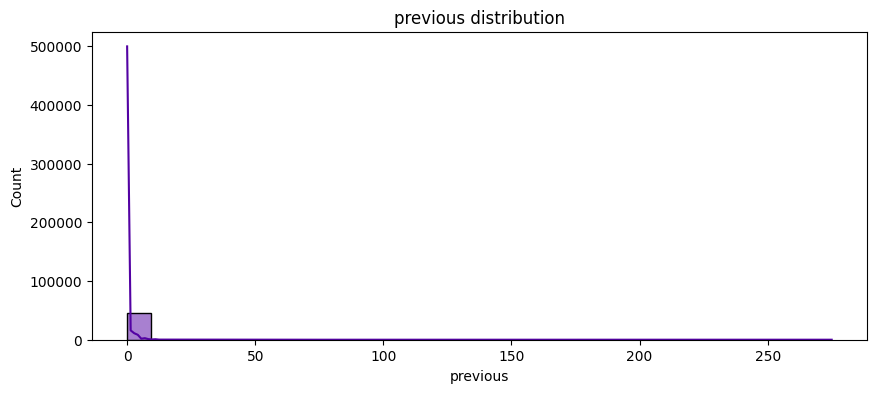

In [139]:
num_cols = df.select_dtypes(include=['int64']).columns.tolist()

for col in num_cols:
    plt.figure(figsize=(10,4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"{col} distribution")
    plt.show()

<h2>Analysing the advertising campaign</h2>

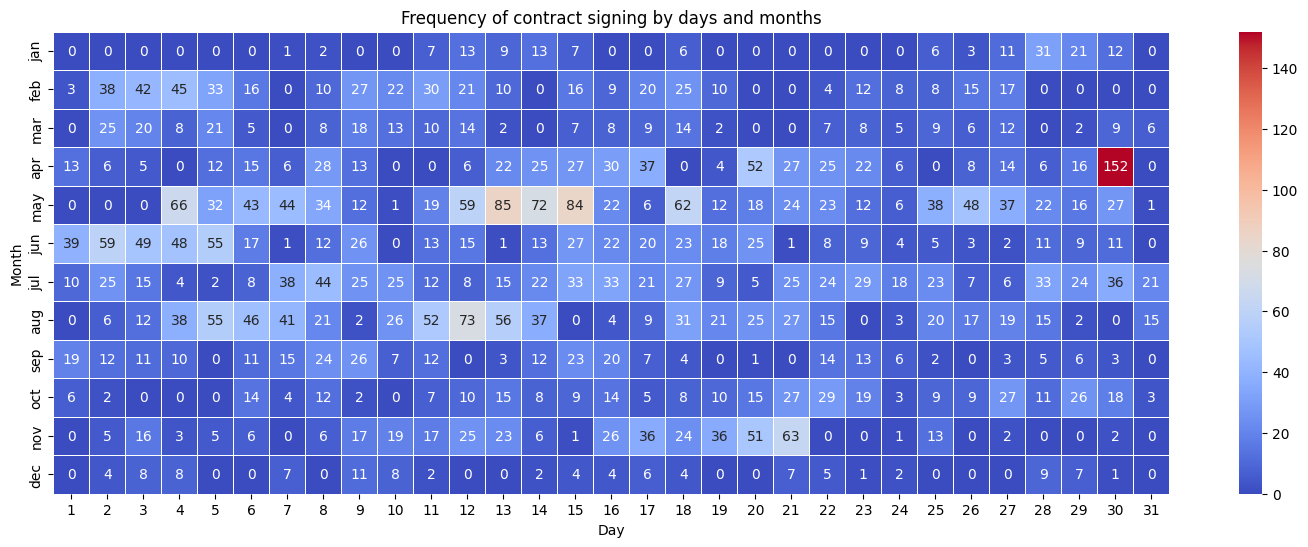

In [145]:
df_success = df[df["y"] == "yes"]
heatmap_data = df_success.pivot_table(index="month", columns="day", aggfunc="size", fill_value=0)
month_order = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
heatmap_data = heatmap_data.reindex(month_order)

plt.figure(figsize=(18,6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt="d", linewidths=0.5)
plt.xlabel("Day")
plt.ylabel("Month")
plt.title("Frequency of contract signing by days and months")
plt.show()

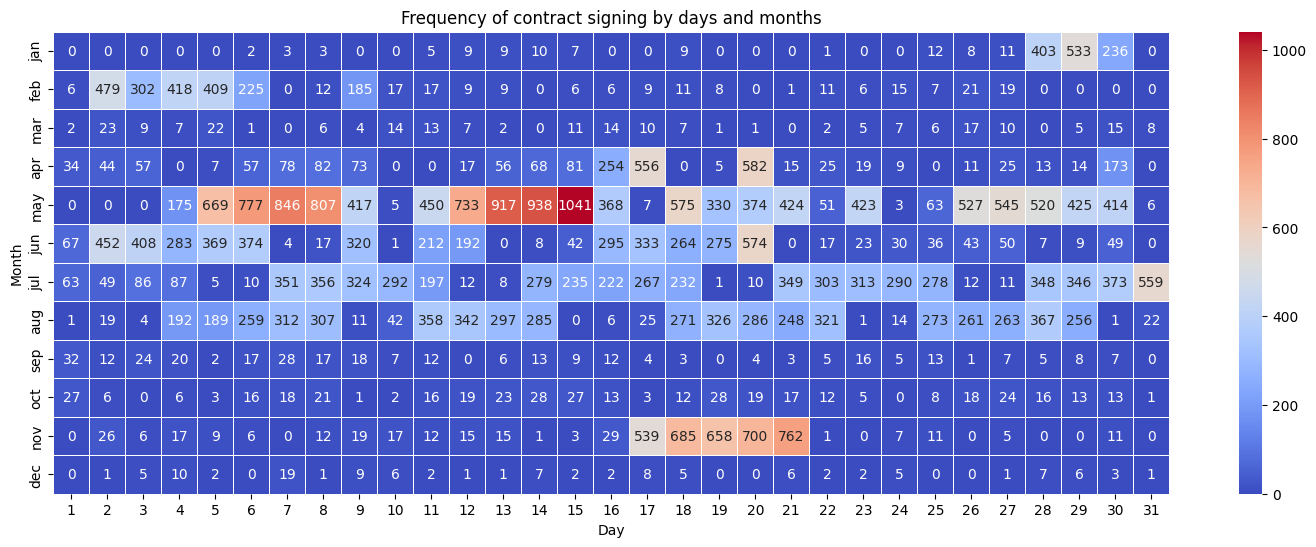

In [146]:
df_success = df[df["y"] == "no"]
heatmap_data = df_success.pivot_table(index="month", columns="day", aggfunc="size", fill_value=0)
month_order = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
heatmap_data = heatmap_data.reindex(month_order)

plt.figure(figsize=(18,6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt="d", linewidths=0.5)
plt.xlabel("Day")
plt.ylabel("Month")
plt.title("Frequency of contract signing by days and months")
plt.show()

In [155]:
day_grouped = df.groupby("day")["y"].value_counts(normalize=True).unstack()
day_total_val = day_grouped [ "yes" ] / (day_grouped [ "yes" ]+ day_grouped [ "no" ])

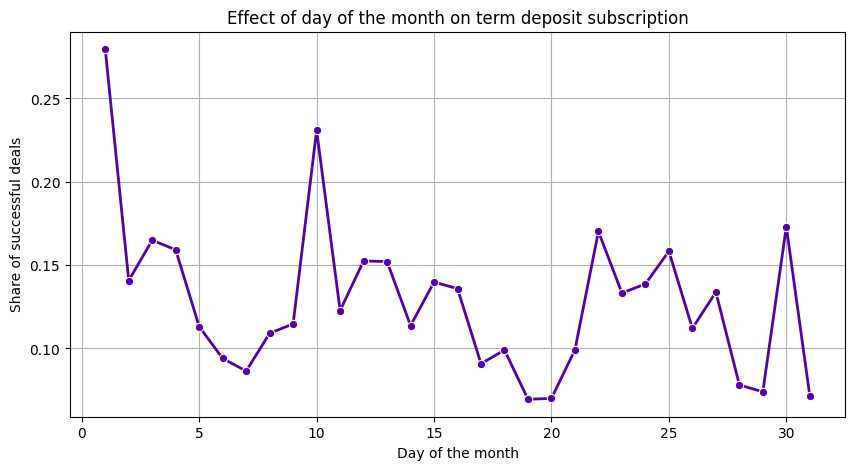

In [156]:
plt.figure(figsize=(10,5))
sns.lineplot(x=day_total_val.index, y=day_total_val.values, marker="o", linewidth=2)
plt.xlabel("Day of the month")
plt.ylabel("Share of successful deals")
plt.title("Effect of day of the month on term deposit subscription")
plt.grid(True)
plt.show()

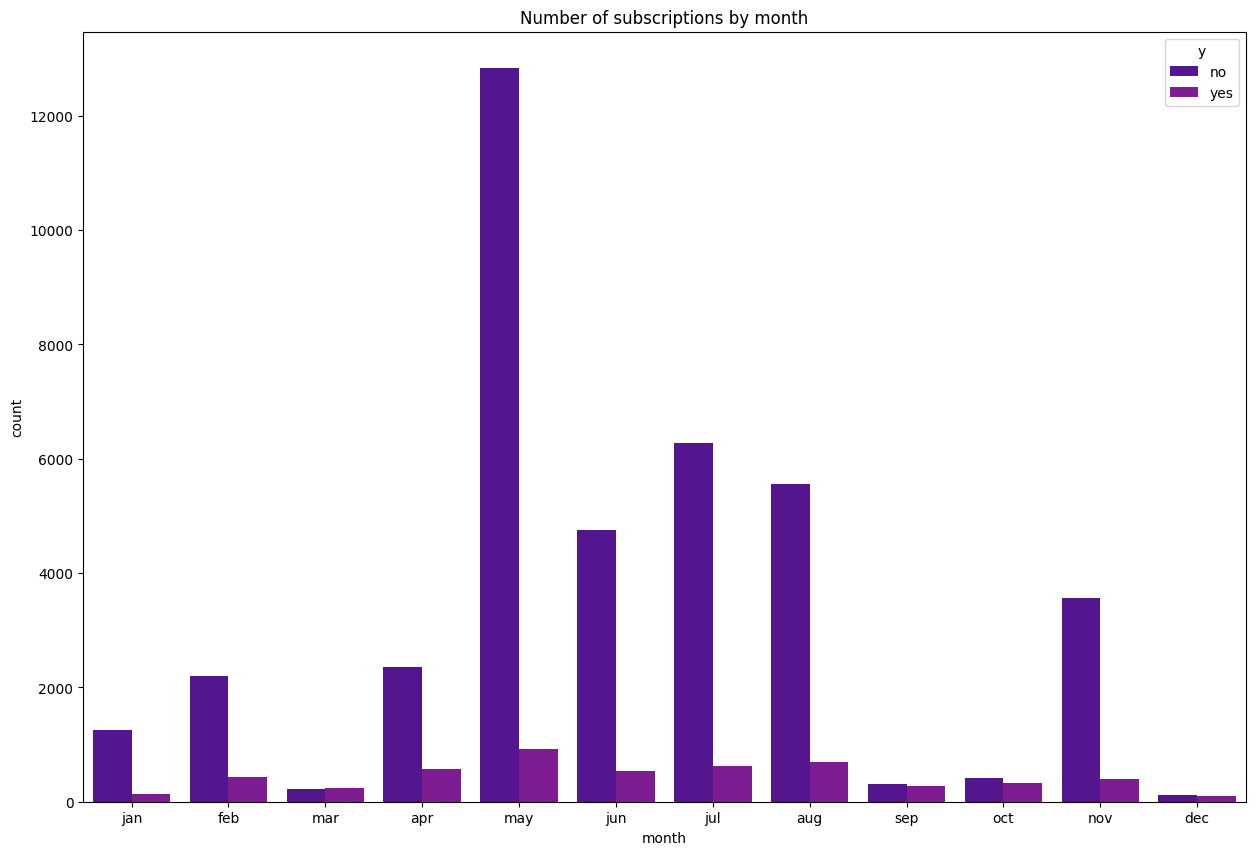

In [152]:
plt.figure(figsize=(15,10))
sns.countplot(data=df, x='month', hue='y', order=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
plt.title("Number of subscriptions by month")
plt.show()

In [153]:
month_grouped = df.groupby("month")["y"].value_counts(normalize=True).unstack()
month_total_val = month_grouped['yes']/(month_grouped['yes']+month_grouped['no'])

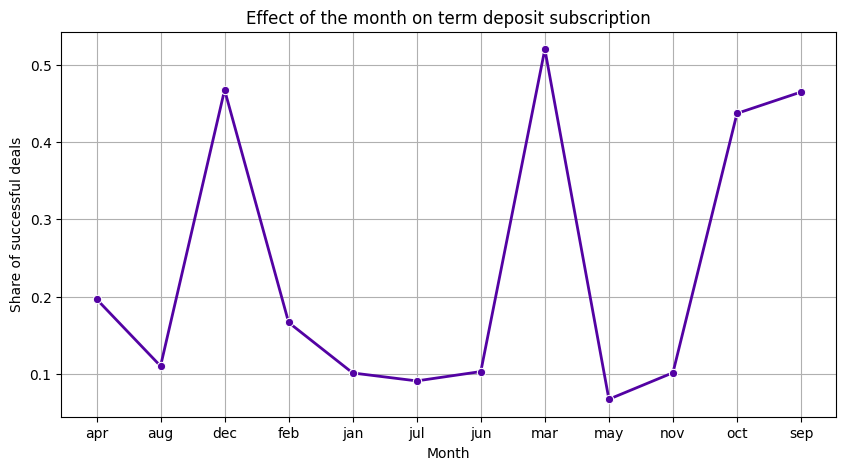

In [154]:
plt.figure(figsize=(10,5))
sns.lineplot(x=month_total_val.index, y=month_total_val.values, marker="o", linewidth=2)
plt.xlabel("Month")
plt.ylabel("Share of successful deals")
plt.title("Effect of the month on term deposit subscription")
plt.grid(True)
plt.show()

Looking at the results obtained - the ratio of positive results to the total number of attempts - we can see that the most successful attempts were made in March, September and December. As for the days, the best attempts were made on the 10th of the month, as well as at the beginning of the month and near the end (29-31) of the month. The most successful means of communication is cellular. 

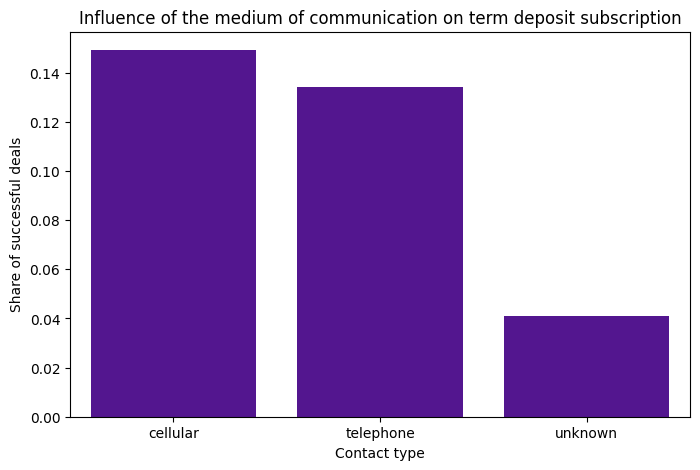

In [30]:
contact_success_rate = df.groupby("contact")["y"].value_counts(normalize=True).unstack()["yes"]

plt.figure(figsize=(8,5))
sns.barplot(x=contact_success_rate.index, y=contact_success_rate.values)
plt.xlabel("Contact type")
plt.ylabel("Share of successful deals")
plt.title("Influence of the medium of communication on term deposit subscription")
plt.show()

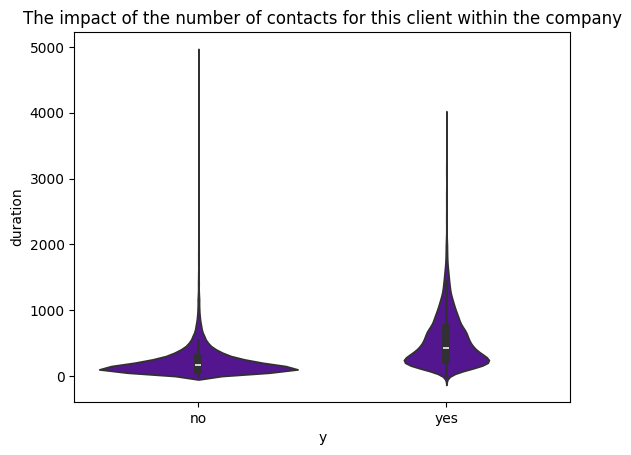

In [174]:
sns.violinplot(data=df, x='y', y='duration')
plt.title("The impact of the number of contacts for this client within the company")
plt.show()

If the client signs a deposit with the bank, their last conversation will usually be longer. 

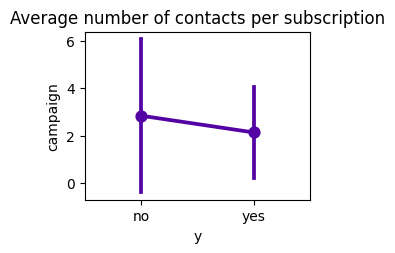

In [178]:
plt.subplot(2, 2, 4)
sns.pointplot(data=df, x="y", y="campaign", errorbar='sd')
plt.title("Average number of contacts per subscription")
plt.show()

The number of contacts is lower when a subscription is made. The bank should make an effort to interest the customer in the first few times of communication. 

The bank can be advised to increase the volume of advertising campaign in these months, as well as to pay attention to the beginning of the month and its end every month. The reason for the anomaly on 30 April can be understood in more detail, for example, by studying news reports. 

<h2>Customer analysis</h2>

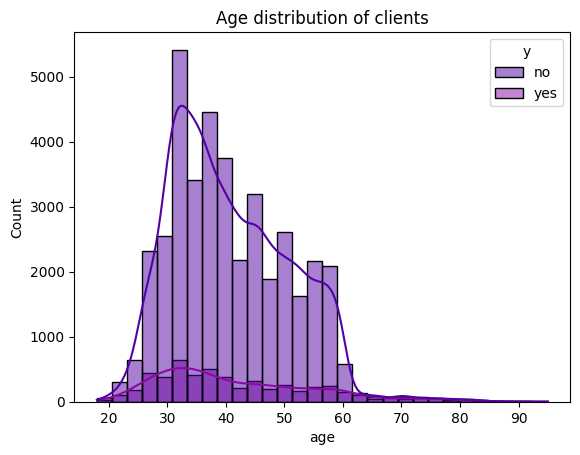

In [157]:
sns.histplot(df, x="age", hue="y", bins=30, kde=True)
plt.title("Age distribution of clients")
plt.show()

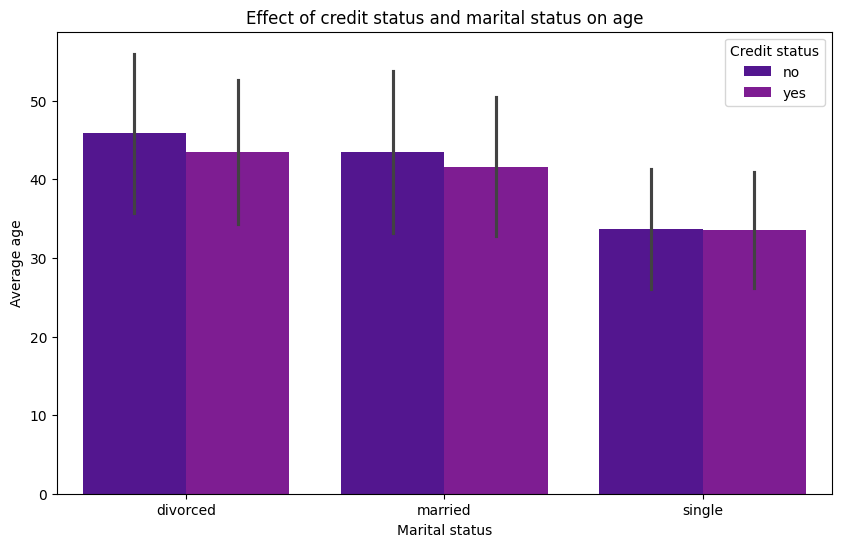

In [183]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="marital", y="age", hue="default", errorbar='sd')
plt.title("Effect of credit status and marital status on age")
plt.xlabel("Marital status")
plt.ylabel("Average age")
plt.legend(title="Credit status")
plt.show()

Text(0.5, 1.0, 'Distribution of clients by profession')

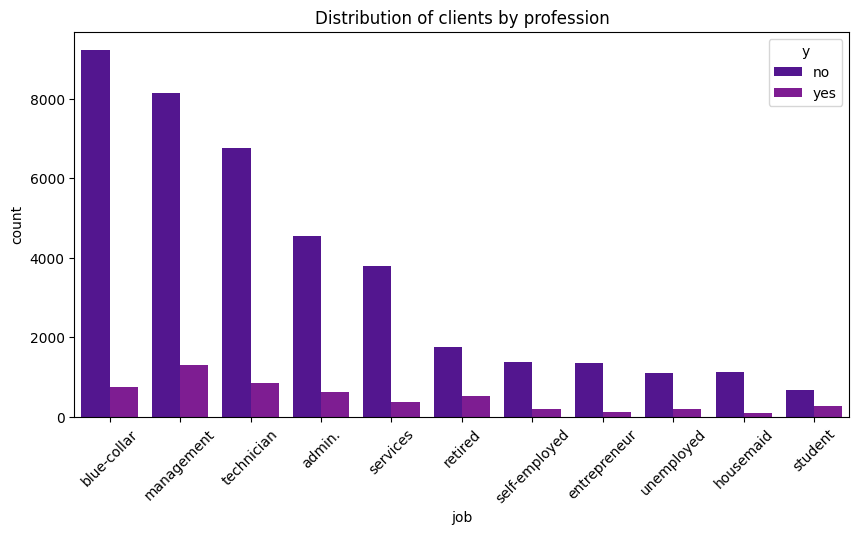

In [158]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='job', hue='y', order=df['job'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of clients by profession")

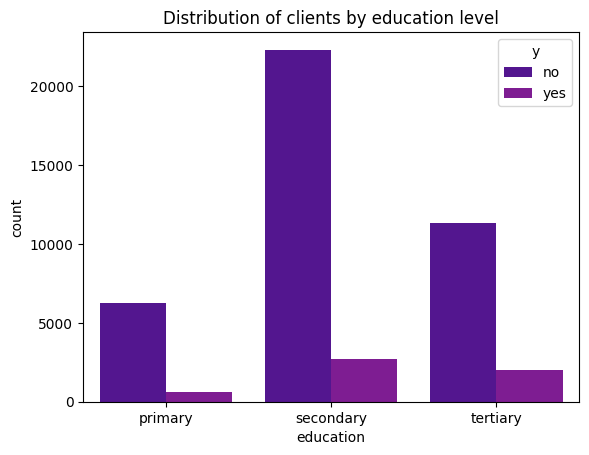

In [159]:
sns.countplot(data=df, x='education', hue='y')
plt.title("Distribution of clients by education level")
plt.show()

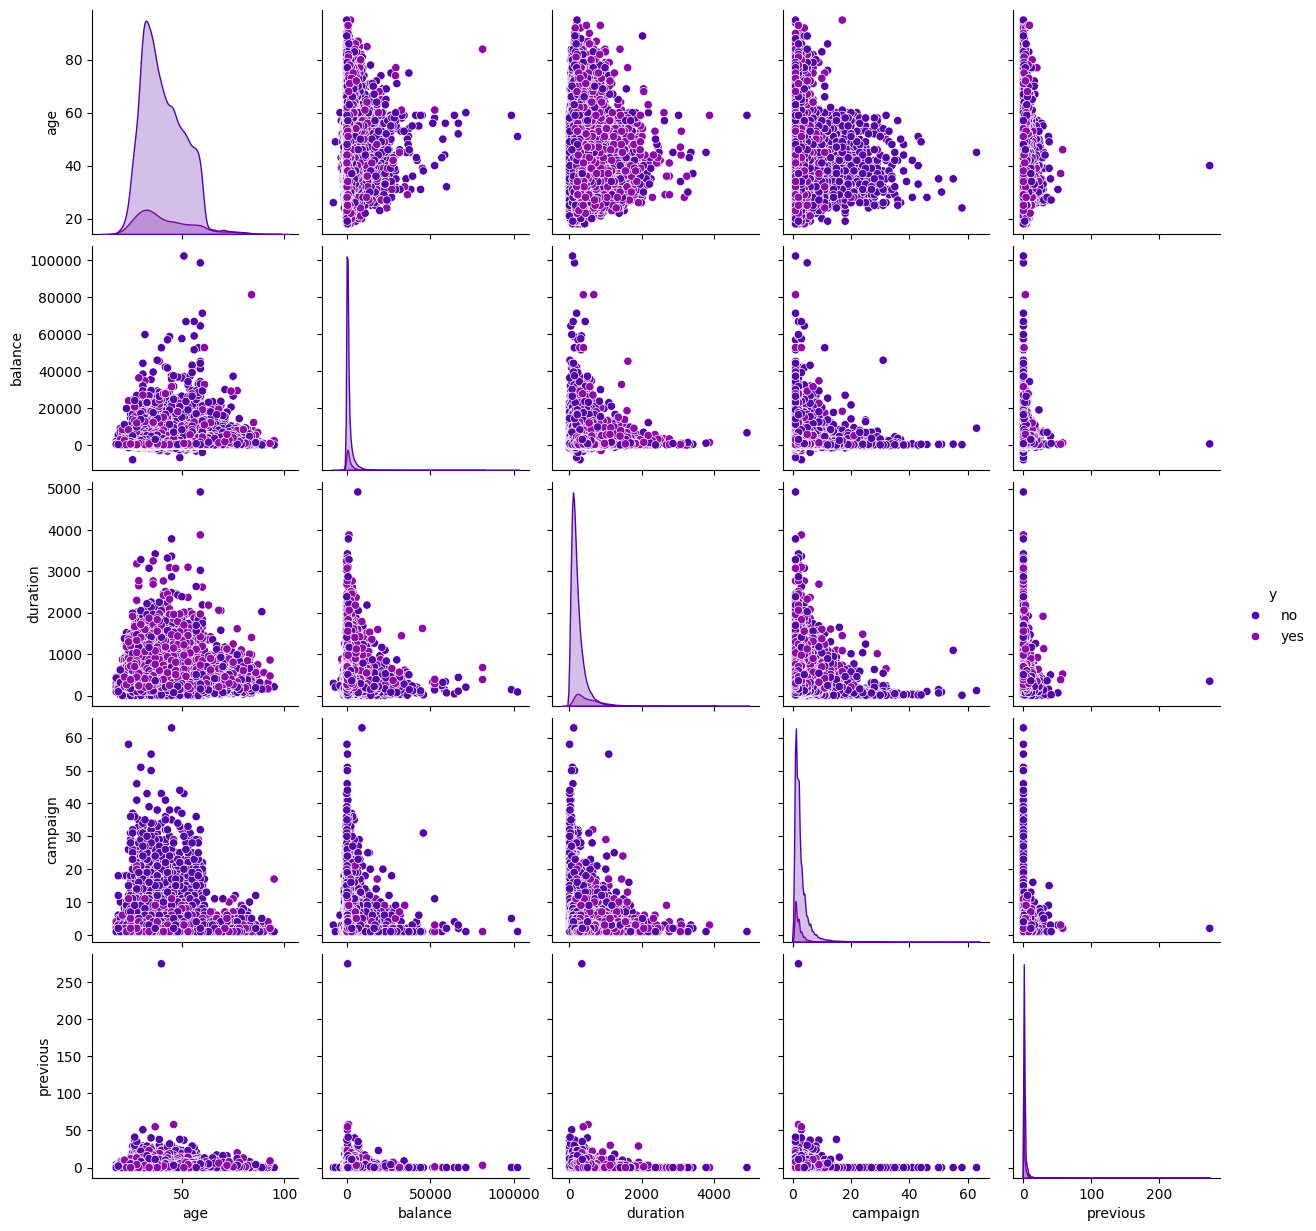

In [168]:
sns.pairplot(df, hue='y', vars=['age', 'balance', 'duration', 'campaign', 'previous'])

Analysing information about clients, it can be seen that different segments of the population, people of different education and age are affected. The Bank should pay more attention to students and pensioners.  

<h2>Analysis of finances</h2>

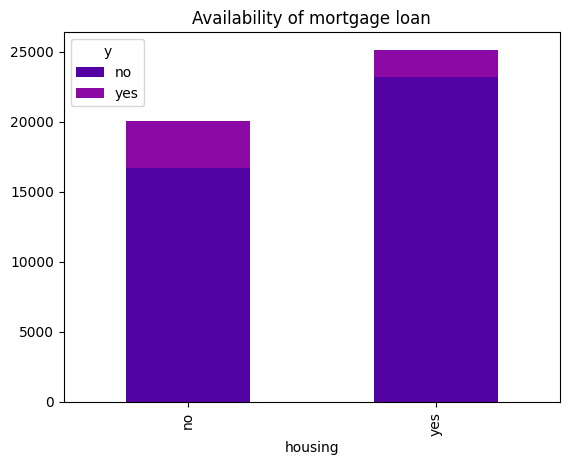

In [164]:
pd.crosstab(df['housing'], df['y']).plot(kind='bar', stacked=True)
plt.title("Availability of mortgage loan")
plt.show()

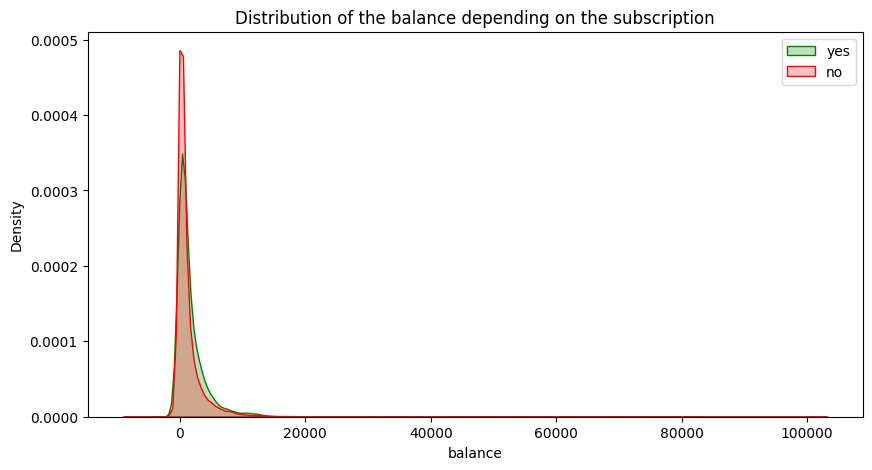

In [180]:
plt.figure(figsize=(10,5))
sns.kdeplot(df[df['y']=='yes']['balance'], fill=True, label="yes", color="green")
sns.kdeplot(df[df['y']=='no']['balance'], fill=True, label="no", color="red")
plt.legend()
plt.title("Distribution of the balance depending on the subscription")
plt.show()

# 3. Feature Engineering

Work is being done with categorical variables. They are encoded using Label Encoder to not greatly increase the number of features in the dataset.

In [199]:
encoder = LabelEncoder()
categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "month","contact", "y"]

for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

In [200]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,0
3,47,1,1,1,0,1506,1,0,2,5,8,92,1,-1,0,0
4,35,4,1,2,0,231,1,0,2,5,8,139,1,-1,0,0


Now that all the attributes are numerical it is possible to check the correlation between them and the target variable. As can be seen the greatest influence on the target variable is duration. there is also a relationship with pdays, and an inverse relationship with contact and housing.

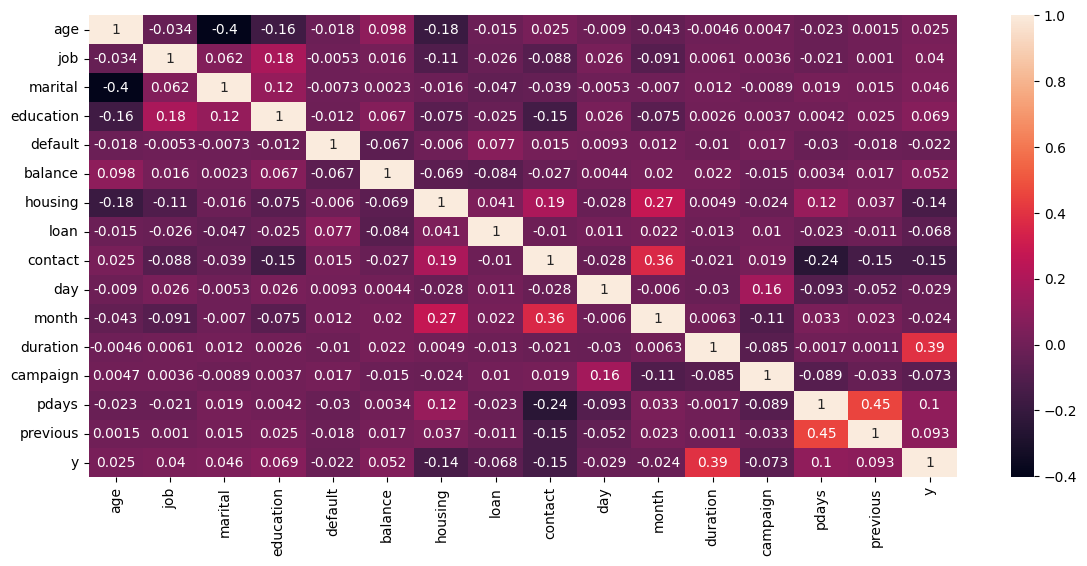

In [201]:
plt.figure(figsize=(14, 6))
sns.heatmap(df.corr(), annot=True)
plt.show()

Almost all variables have a relationship with the target variable. It would be possible to remove "age", "default" and "day" within feature selection, but this will not be done. 

In [202]:
df.corr()['y'][:].sort_values(ascending =False)

y            1.000000
duration     0.394624
pdays        0.103498
previous     0.093162
education    0.068566
balance      0.052467
marital      0.045620
job          0.040446
age          0.025366
default     -0.022425
month       -0.024434
day         -0.028538
loan        -0.068364
campaign    -0.073137
housing     -0.139625
contact     -0.148067
Name: y, dtype: float64

During the data analysis phase, it was found that some numerical features were highly skewed, which could greatly affect the accuracy of the models. In order to remove this, logarithmisation was applied. 

In [39]:
df["duration"] = np.log1p(df["duration"])
df["campaign"] = np.log1p(df["campaign"])
df["pdays"] = np.log1p(df["pdays"] + 1)
df["balance"] = np.sign(df["balance"]) * np.log1p(abs(df["balance"]))

The dataset was categorised into traits and target variable, training and test samples. 

In [40]:
X = df.drop(columns=['y'])
y = df['y'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape)
print(y_train.shape)

(36125, 15)
(36125,)


Standardisation was applied to bring the numerical attributes, which are capable of different very different scales, to one. 

In [41]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Further, it is further confirmed that the number of instances in the target variable classes is highly unequal. 

In [42]:
df["y"].value_counts()
print(df["y"].value_counts()[0]/df["y"].value_counts()[1])

7.539523449319213


# Model Building

<h2>Class Weights approach</h2>

In [43]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1] *1.5}

In [44]:
models = {
    "Decision Tree": DecisionTreeClassifier(class_weight=class_weights_dict, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight=class_weights_dict, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(scale_pos_weight=class_weights_dict[0] / class_weights_dict[1], random_state=42)
}


In [45]:
def work_with_models(models_dict, X_train= X_train, y_train= y_train):
    results = {}
    for name, model in models_dict.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results[name] = {"accuracy": acc, "precision": prec, "recall": rec, "f1-score": f1, "conf_matrix": confusion_matrix(y_test, y_pred)}
    return results

In [46]:
def print_results(results_dict):
    for name, metrics in results_dict.items():
        print(f"\n\t {name}")
        for metric, value in metrics.items():
            if metric != "conf_matrix":
                print(f"{metric}: {value:.4f}")

In [47]:
def plot_results(results_dict):
    _, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, (name, metrics) in zip(axes, results_dict.items()):
        sns.heatmap(metrics["conf_matrix"], annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(f"Confusion Matrix: {name}")
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")

    plt.tight_layout()
    plt.show()

In [48]:
results_cw = work_with_models(models)
print_results(results_cw)


	 Decision Tree
accuracy: 0.8760
precision: 0.4681
recall: 0.4301
f1-score: 0.4483

	 Random Forest
accuracy: 0.8985
precision: 0.6523
recall: 0.2854
f1-score: 0.3971

	 XGBoost
accuracy: 0.8880
precision: 0.7738
recall: 0.0614
f1-score: 0.1138


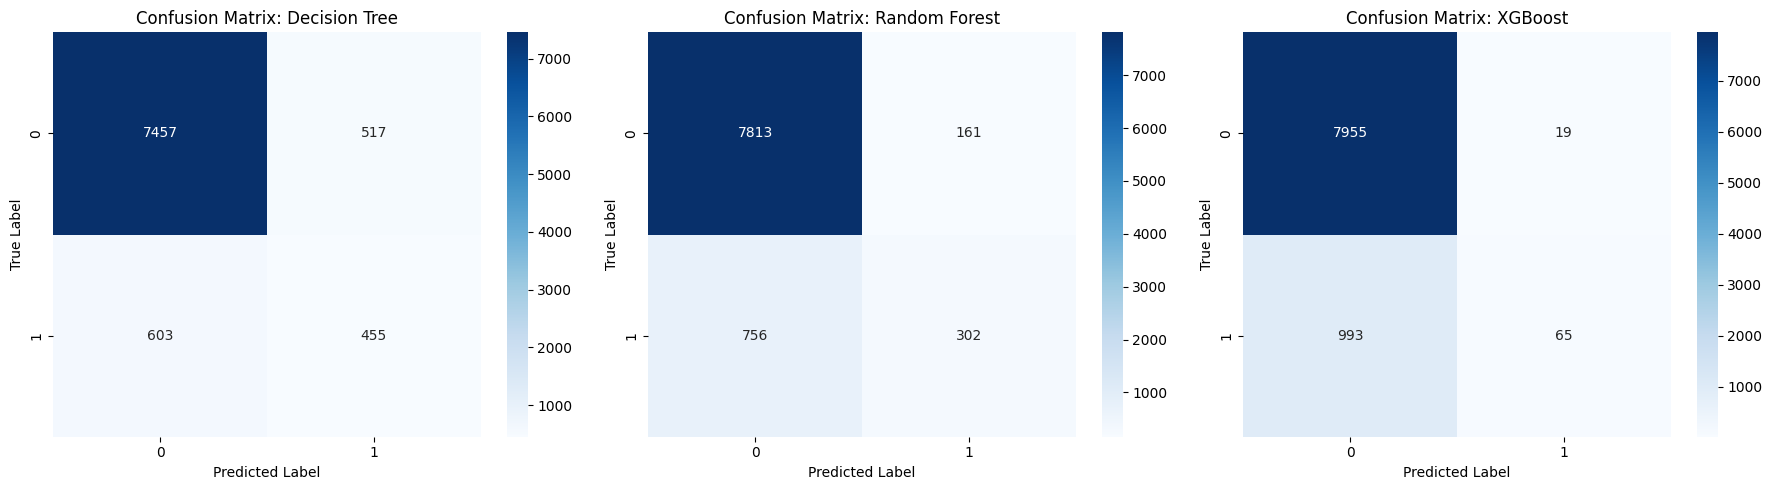

In [49]:
plot_results(results_cw)

<h2>SMOTE</h2>

In [50]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Class balance after SMOTE: {dict(pd.Series(y_train_resampled).value_counts())}")


Class balance after SMOTE: {0: 31895, 1: 31895}


In [51]:
models_SMOTE = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier( random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42)
}

In [52]:
results_smote = work_with_models(models_SMOTE, X_train_resampled, y_train_resampled)
print_results(results_smote)


	 Decision Tree
accuracy: 0.8664
precision: 0.4446
recall: 0.5652
f1-score: 0.4977

	 Random Forest
accuracy: 0.8944
precision: 0.5412
recall: 0.6456
f1-score: 0.5888

	 XGBoost
accuracy: 0.9031
precision: 0.5837
recall: 0.6030
f1-score: 0.5932


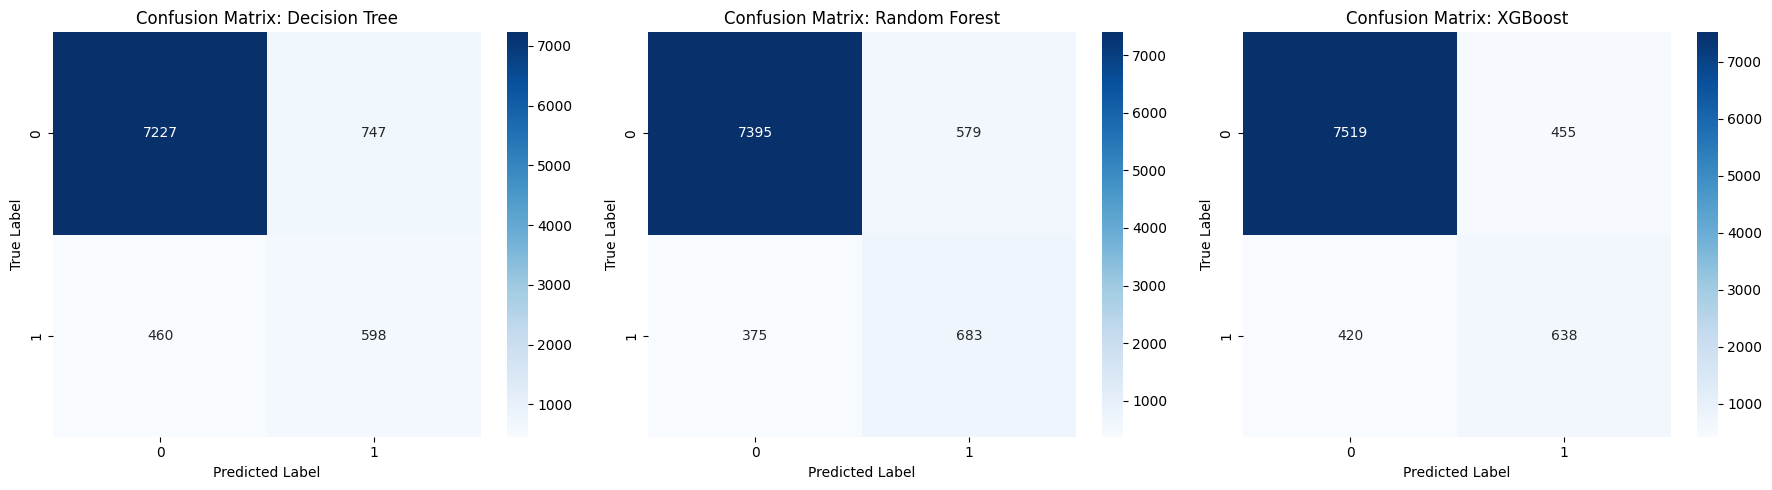

In [53]:
plot_results(results_smote)

In [54]:
models_SMOTE2 = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "SVM": SVC(random_state=42),
    "KNN": KNeighborsClassifier()
}
results_smote2 = work_with_models(models_SMOTE2)
print_results(results_smote2)


	 LogisticRegression
accuracy: 0.8916
precision: 0.5828
recall: 0.2628
f1-score: 0.3622

	 SVM
accuracy: 0.8940
precision: 0.6656
recall: 0.1919
f1-score: 0.2979

	 KNN
accuracy: 0.8895
precision: 0.5558
recall: 0.2826
f1-score: 0.3747


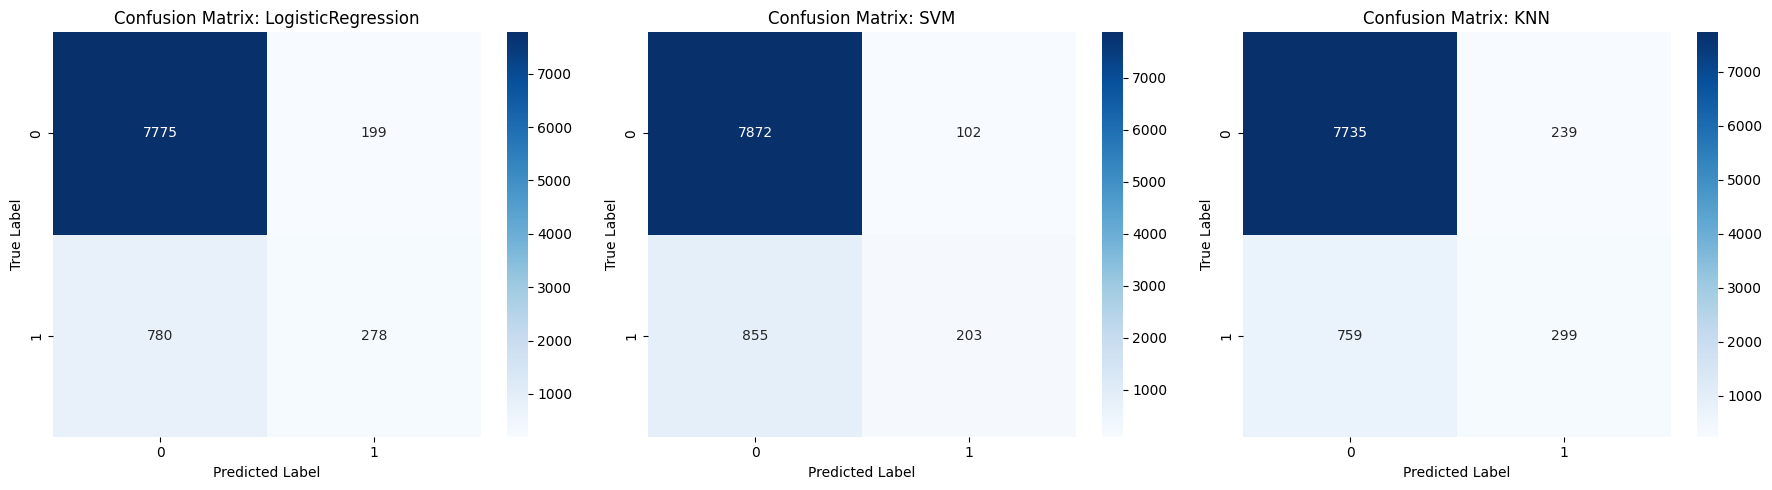

In [55]:
plot_results(results_smote2)

# Performance evaluation

In [72]:
models = list(results_cw.keys())
accuracy = [results_cw[m]['accuracy'] for m in models]
precision = [results_cw[m]['precision'] for m in models]
recall = [results_cw[m]['recall'] for m in models]
f1_score = [results_cw[m]['f1-score'] for m in models]

models2 = list(results_smote.keys())
accuracy2 = [results_smote[m]['accuracy'] for m in models2]
precision2 = [results_smote[m]['precision'] for m in models2]
recall2 = [results_smote[m]['recall'] for m in models2]
f1_score2 = [results_smote[m]['f1-score'] for m in models2]

models3 = list(results_smote2.keys())
accuracy3 = [results_smote2[m]['accuracy'] for m in models3]
precision3 = [results_smote2[m]['precision'] for m in models3]
recall3 = [results_smote2[m]['recall'] for m in models3]
f1_score3 = [results_smote2[m]['f1-score'] for m in models3]

Next, a comparison of the quality metrics of the models trained on data with different approaches to handling the imbalance of values in the target variable is performed. As can be seen, models trained on data after SMOTE show higher accuracy, and more importantly higher values for precision, recall and f1_score.

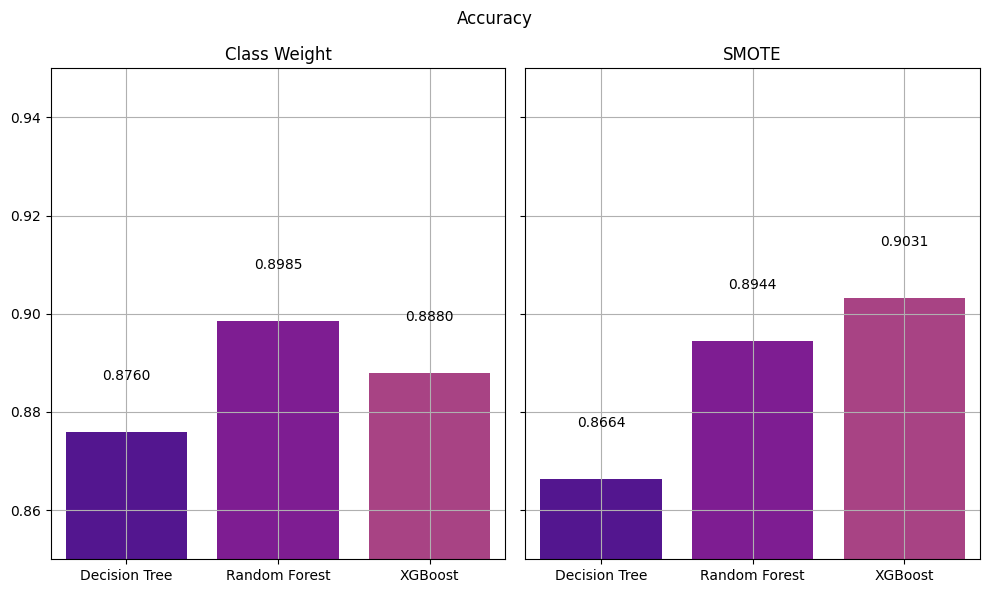

In [108]:
def setup_plot(ax, y_data, title, y_limits=(0.0, 1.0)):
    sns.barplot(x=models, y=y_data, ax=ax, hue = models)
    ax.set_title(title)
    ax.set_ylim(y_limits)

    for i, value in enumerate(y_data):
        ax.text(i, value + 0.01, f'{value:.4f}', ha='center', va='bottom', fontsize=10, color='black')

    ax.grid(True)

fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True)
setup_plot(axs[0], accuracy, 'Class Weight', y_limits = (0.85, 0.95))
setup_plot(axs[1], accuracy2, 'SMOTE', y_limits = (0.85, 0.95))
plt.suptitle('Accuracy')
plt.tight_layout()
plt.show()

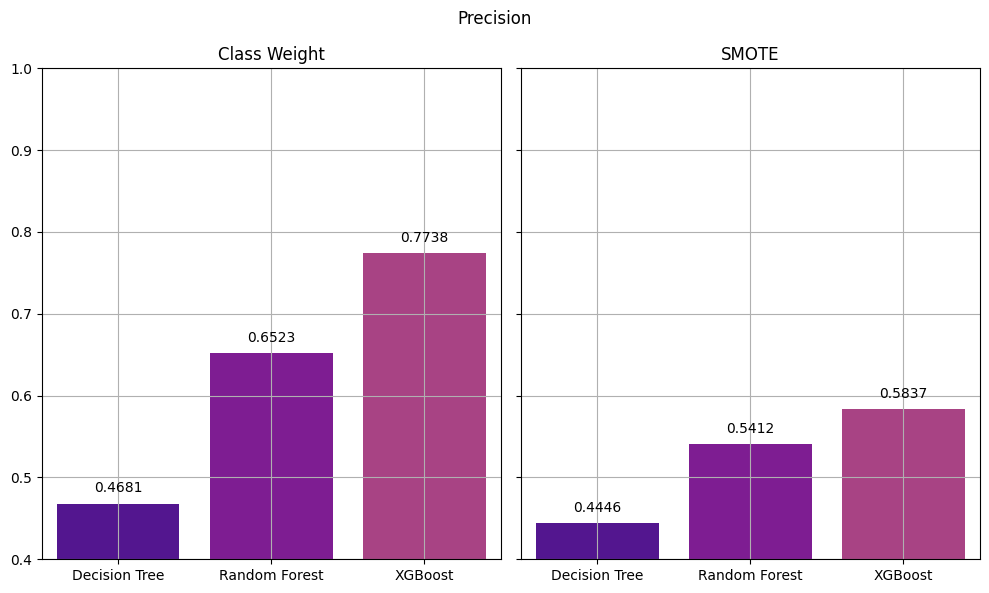

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True)
setup_plot(axs[0], precision, 'Class Weight', y_limits = (0.4, 1.0))
setup_plot(axs[1], precision2, 'SMOTE', y_limits = (0.4, 1.0))
plt.suptitle('Precision')
plt.tight_layout()
plt.show()

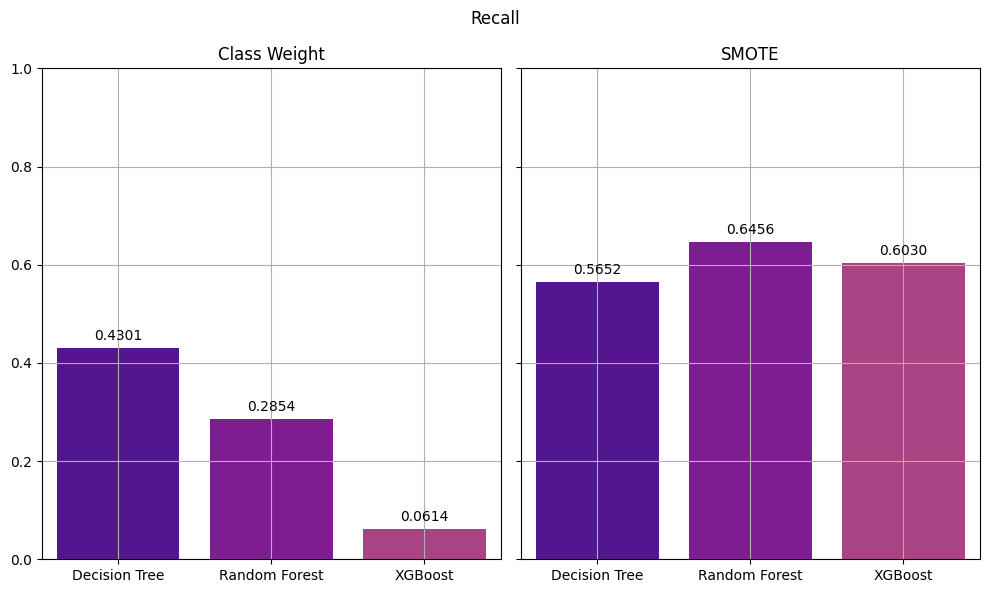

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True)
setup_plot(axs[0], recall, 'Class Weight')
setup_plot(axs[1], recall2, 'SMOTE')
plt.suptitle('Recall')
plt.tight_layout()
plt.show()

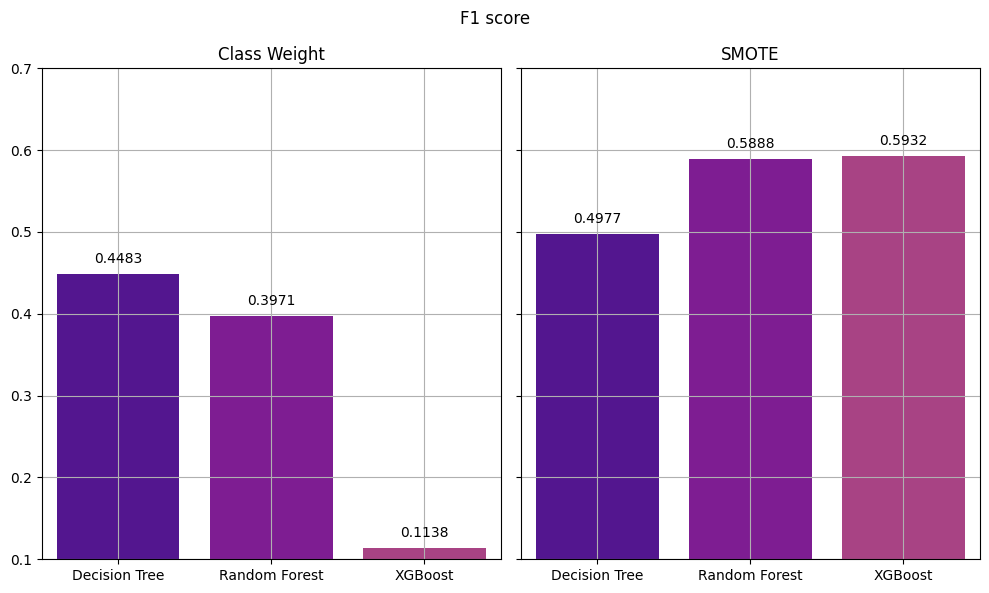

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True)
setup_plot(axs[0], f1_score, 'Class Weight', y_limits = (0.1, 0.7))
setup_plot(axs[1], f1_score2, 'SMOTE', y_limits = (0.1, 0.7))
plt.suptitle('F1 score')
plt.tight_layout()
plt.show()

Using the SMOTE method to deal with highly unbalanced data, simpler machine learning models such as Logisticregression, SVM, KNN have also been trained. The obtained accuracy results were compared with the results of models trained also on data after SMOTE.

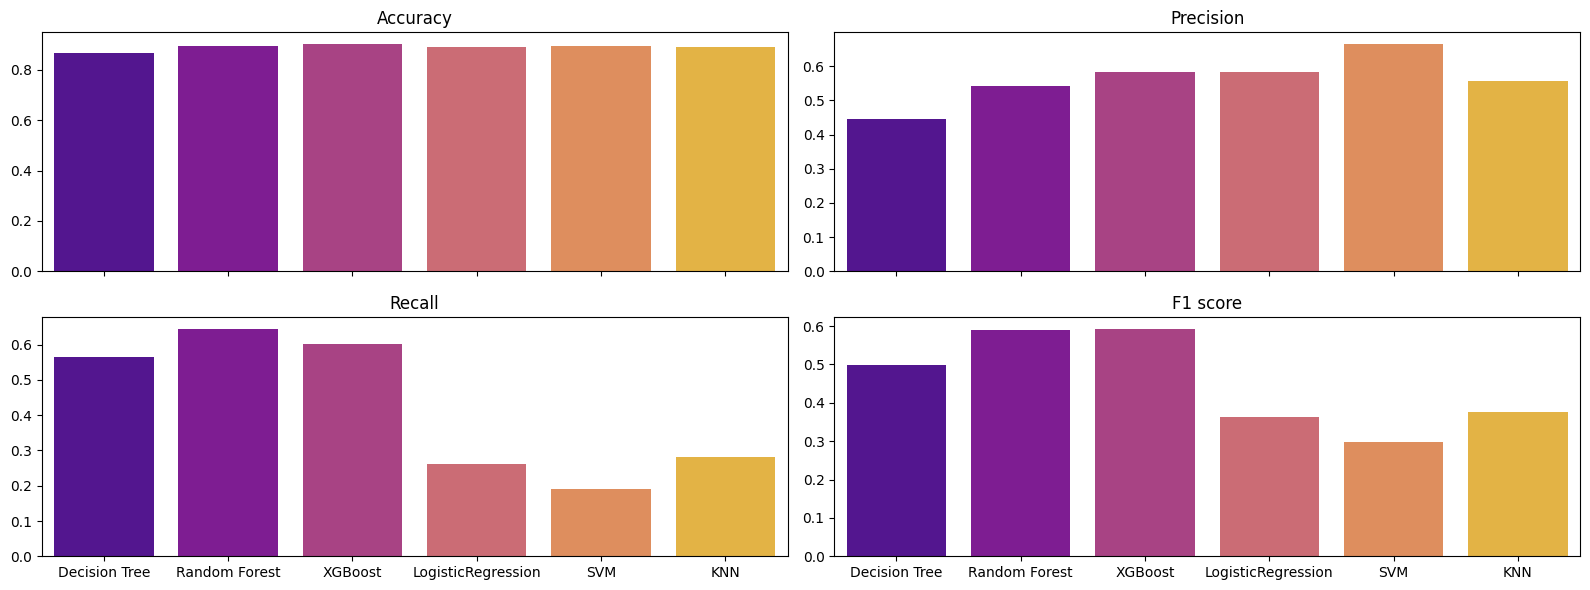

In [79]:
all_smote_models = models2 + models3
smote_accuracy = accuracy2 + accuracy3
smote_precision= precision2 + precision3
smote_recall= recall2 + recall3
smote_f1= f1_score2 +f1_score3

fig, axs = plt.subplots(2, 2, figsize=(16,6), sharex=True)
sns.barplot(x= all_smote_models, y = smote_accuracy, hue = all_smote_models, ax = axs[0, 0])
axs[0, 0].set_title("Accuracy")

sns.barplot(x= all_smote_models, y = smote_precision,  hue = all_smote_models, ax = axs[0, 1])
axs[0, 1].set_title("Precision")

sns.barplot(x= all_smote_models, y = smote_recall,  hue = all_smote_models, ax = axs[1, 0])
axs[1, 0].set_title("Recall")

sns.barplot(x= all_smote_models, y = smote_f1,  hue = all_smote_models, ax = axs[1, 1])
axs[1, 1].set_title("F1 score")

plt.tight_layout()
plt.show()

As can be seen, the XGBoost models showed the highest accuracy, slightly less than Random Forest, which can be fully used for this dataset if there is a need for fast model training. Of the simpler models, LogisticRegression did well in all accuracy scores.

# Tuning hyperparameters

Next, an attempt is made to improve the accuracy of the gradient bousting model by selecting hyperparameters.

In [90]:
xgb_model = XGBClassifier(eval_metric="logloss", random_state=42)

param_dist = {
    'max_depth': [3, 6, 9, 12, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 500],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0, 0.1, 1, 10],
}

random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1,
                                    scoring='accuracy', random_state=42, verbose=2
)

In [92]:
random_search.fit(X_train_resampled, y_train_resampled)
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best score: 0.9407430631760464


In [93]:
best_model = random_search.best_estimator_
y_pred_bm = best_model.predict(X_test)
print(classification_report(y_test, y_pred_bm))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7974
           1       0.55      0.64      0.59      1058

    accuracy                           0.90      9032
   macro avg       0.75      0.79      0.77      9032
weighted avg       0.90      0.90      0.90      9032



In [ ]:
print("Comparison model accuracy before and after hyperparameters tuning")
print(f"Best score: {random_search.best_score_}")

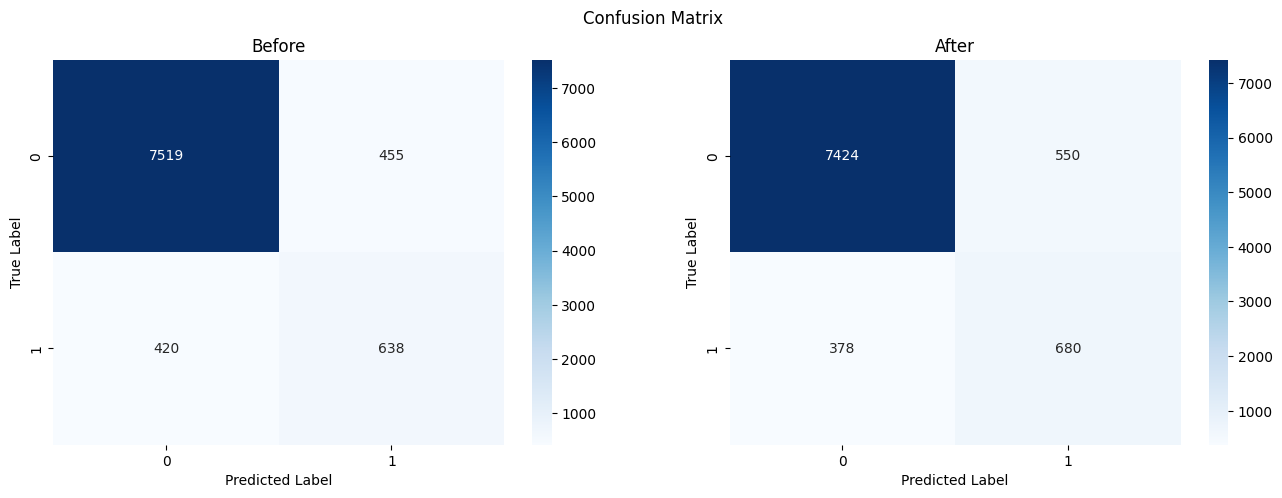

In [107]:
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
sns.heatmap(results_smote['XGBoost']['conf_matrix'], annot=True, fmt="d", cmap="Blues", ax = axs[0])
axs[0].set_title("Before")
sns.heatmap(confusion_matrix(y_test, y_pred_bm), annot=True, fmt="d", cmap="Blues", ax = axs[1])
axs[1].set_title("After")
plt.suptitle("Confusion Matrix")
for ax in axs:
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
plt.show()

It can be seen that the accuracy has increased after fitting the parameters. As for the results presented in confussion_matricx, the number of True Positive values has slightly decreased, but the number of True Negative values has significantly increased, which is a more significant result, given that y=“yes” values were initially few in the set and the main problem that the other models suffered from was the problem of predicting this particular class. 

The final model to implement is XGBoost with the selected hyperparameters. As measures to improve accuracy in the future, one can continue to tune its parameters, by narrowing the values for the obtained values when searching their Random Search, using the Grid Search already in place. You can also increase the dataset by adding more y=“yes” values.